In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

A function can be represented by function values at a number of points. If we draw these values from a standard Gaussian distribution, it will look like this:

In [3]:
N = 50
x = np.linspace(-8, 8, N) #[:, np.newaxis]

mu = np.zeros((N))
C = np.eye(N)

rv_samples = multivariate_normal(mu, C).rvs(size=5)

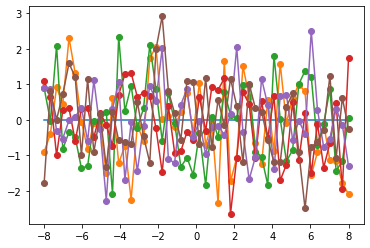

In [4]:
plt.plot(x, mu)
plt.plot(x, rv_samples.T, "o-");

If we now specify a special covariance matrix, the result will look rather different. 

In [5]:
C = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        C[i,j] = 10. * np.exp(-1. * (x[i] - x[j])**2)

# to make sure, C is positive definite, we can add a small value to the diagonal
C = C + 0.001*np.eye(N)

In [6]:
# vectorized version:
C = 10.*np.exp(-1.*np.power((x[:,np.newaxis] - x[np.newaxis,:]), 2)) + 0.001 * np.eye(N)

We can draw samples from any Gaussian distribution by transforming a standard Gaussian using the following formula:

$$ \mathcal{N}(x; \mu, \sigma^2) = \mu + \sigma \cdot \mathcal{N}(x; 0, 1) $$


In the multivariate case, the same can be done by using Cholesky factorization:

$$ \Sigma = LL^T $$

$$ \mathcal{N}(\boldsymbol x; \boldsymbol \mu, \boldsymbol \Sigma) = \boldsymbol \mu + L \cdot \mathcal{N}(\boldsymbol x; \boldsymbol 0, \boldsymbol 1) $$

In [7]:
# from the normal distribution (mu,C) a random vector can be drawn by using Cholesky factorization:
L = np.linalg.cholesky(C)
z = np.random.normal(0,1, (len(mu), 5))

rv_samples2 = L @ z #+ mu[:, np.newaxis]
rv_samples2.shape

(50, 5)

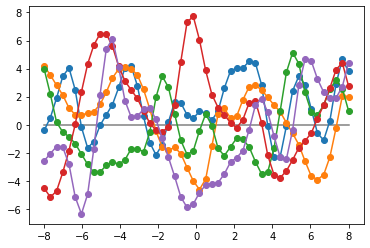

In [8]:
plt.plot(x, mu, color="grey")
plt.plot(x, rv_samples2, "o-");

By computing the covariance matrix this way, the 'function samples' 
The function used to compute the covariance matrix is called RBF kernel function (other names for the same function are Squared Exponential (SE) or Gaussian)

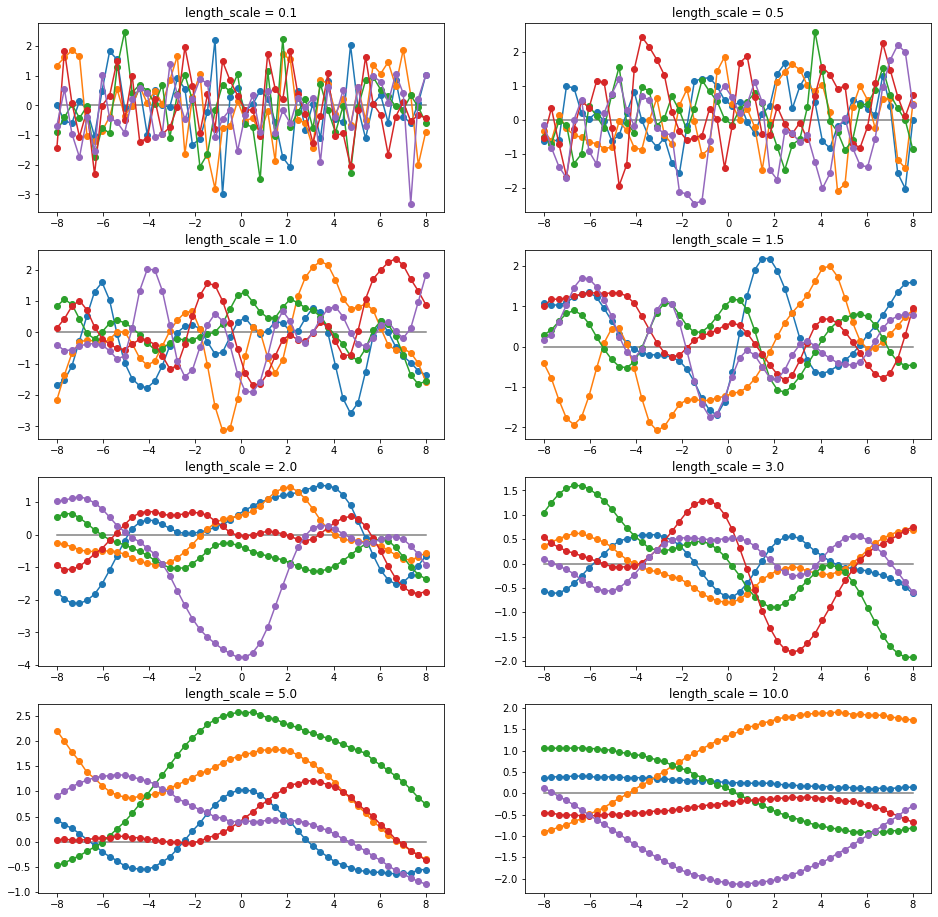

In [9]:
fig = plt.figure(figsize=(16,16))

for i, length_scale in enumerate([1e-1, 0.5, 1., 1.5, 2., 3., 5., 1e01]):
    C = np.exp(-np.power((x[:,np.newaxis] - x[np.newaxis,:]) / length_scale, 2)) + 0.0001 * np.eye(N)
    
    rv = multivariate_normal(mu, C)
    L = np.linalg.cholesky(C)
    z = np.random.normal(0, 1, (len(mu), 5))
    rv_samples = L @ z #+ mu[:, np.newaxis]
    
    ax = fig.add_subplot(4, 2, i+1)
    ax.plot(x, mu, color="grey")
    ax.plot(x, rv_samples, "o-")
    ax.set_title(f"length_scale = {length_scale}")

### _=> Priors in function space can be specified by using a kernel function_

In [10]:
N_grid = 50
xmin = 0
xmax = 1

x = np.linspace(xmin, xmax, N_grid)

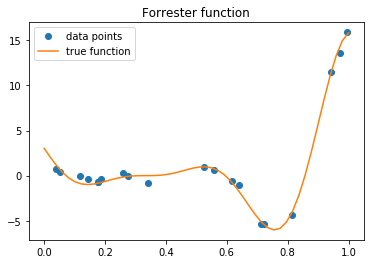

In [11]:
def f(x, noise_lvl=0.):
    return (6*x - 2)**2 * np.sin(12*x - 4) + np.random.normal(0, 1, x.shape)*noise_lvl

# Training Data
N_data = 20
x_data = np.sort(np.random.rand(N_data)*(xmax-xmin) + xmin)
X = x_data = x_data[:, np.newaxis]


Y = y_data = f(x_data[:,0], 0.5)[:, np.newaxis]

plt.plot(x_data, y_data, 'o', label="data points")
plt.plot(x, f(x), '-', label="true function")
plt.gca().set_title("Forrester function")
plt.legend()

In [12]:
def rbf_kernel(xa, xb, length_scale=1., var=1.):
    K = np.zeros((len(xa), len(xb)))
    for i,u in enumerate(xa):
        for j,v in enumerate(xb):
            d = u - v            
            K[i,j] = - np.dot(d, d/length_scale)
        
    return var**2 * np.exp(K)

In [13]:
length_scale = 0.01
var = 1.
sigma = 0.5

k_xx = rbf_kernel(x, x, length_scale, var)
k_XX = rbf_kernel(x_data, x_data, length_scale, var)
k_xX = rbf_kernel(x, x_data, length_scale, var)
k_Xx = k_xX.T

In [16]:
# warning: this operation might become unstable for some covariance matrices

C_inv = np.linalg.inv(k_XX + sigma*np.eye(N_data))

mu_post = k_xX @ C_inv @ Y

cov_post = k_xx - k_xX @ C_inv @ k_Xx
std_post = np.sqrt(np.diag(cov_post))

In [17]:
# a more stable alternative:

a = np.linalg.solve(k_XX + sigma*np.eye(N_data), k_xX.T).T

mu_post = a @ Y

cov_post = k_xx - a @ k_Xx
std_post = np.sqrt(np.diag(cov_post))

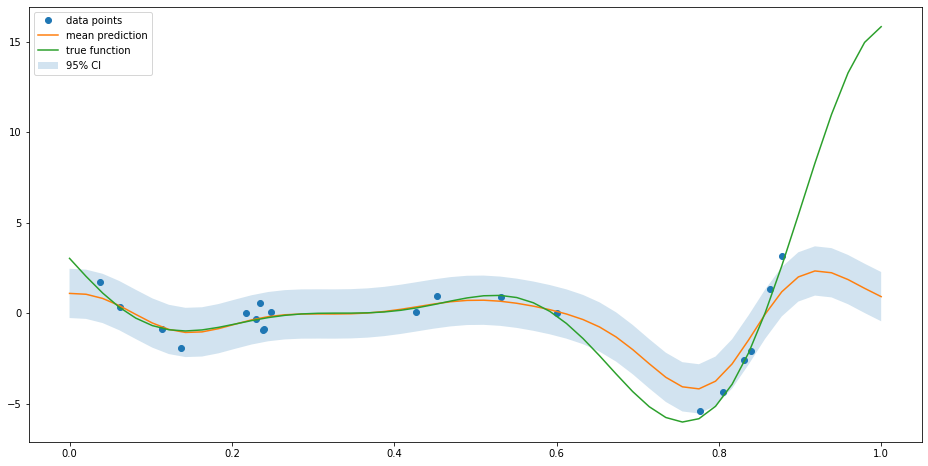

In [15]:
plt.figure(figsize=(16,8))
plt.plot(x_data, y_data, 'o', label="data points")
plt.plot(x, mu_post, '-', label="mean prediction")
plt.plot(x, f(x), '-', label="true function")

y_upper = mu_post + 2*std_post
y_lower = mu_post - 2*std_post
plt.fill_between(x, y_upper[:,0], y_lower[:,0], alpha=0.2, label="95% CI")

plt.legend()

### Warning: The following code might be numerically unstable. It's only intended for educational purposes!

In [16]:
def mll(args):
    length_scale_exponent, var_exponent = args
    
    length_scale = np.power(10, length_scale_exponent)
    var = np.power(10, var_exponent)
    
    k_XX = rbf_kernel(x_data, x_data, length_scale, var)
    
    return multivariate_normal(np.zeros((N_data)), k_XX + sigma * np.eye(N_data)).logpdf(y_data).sum()


In [17]:
var_exponent_values = np.linspace(-4, 4, 20)
length_scale_exponent_values = np.linspace(-5, -2, 20)

mll_values = np.zeros((20,20))


for i, ls_exp in enumerate(length_scale_exponent_values):
    for j, var_exp in enumerate(var_exponent_values):
        #print(ls_exp, var_exp)
        mll_values[i,j] = mll((ls_exp, var_exp))

Text(0.5, 1.0, 'Marginal Log-Likelihood')

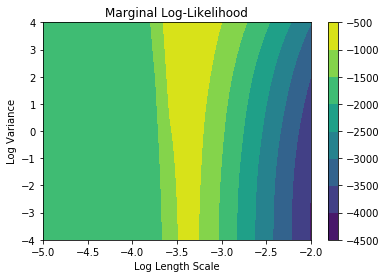

In [18]:
fig, ax = plt.subplots()
cf = ax.contourf(length_scale_exponent_values, var_exponent_values, mll_values)
fig.colorbar(cf, ax=ax)
ax.set_xlabel("Log Length Scale")
ax.set_ylabel("Log Variance")
ax.set_title("Marginal Log-Likelihood")

In [19]:
imax = np.argmax(mll_values)
i,j = np.unravel_index(imax, mll_values.shape)
print(i, j, mll_values[i,j])

19 10 -502.29273090161


In [20]:
length_scale_exponent = length_scale_exponent_values[i]
var_exponent = var_exponent_values[j]

length_scale = np.power(10, length_scale_exponent)
var = np.power(10, var_exponent)

length_scale, var

(0.01, 1.623776739188721)

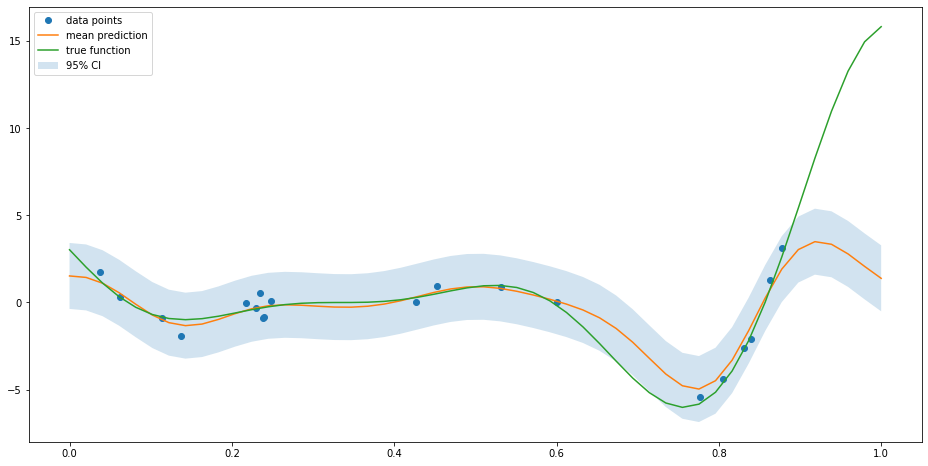

In [21]:
k_xx = rbf_kernel(x, x, length_scale, var)
k_XX = rbf_kernel(x_data, x_data, length_scale, var)
k_xX = rbf_kernel(x, x_data, length_scale, var)
k_Xx = k_xX.T

a = np.linalg.solve(k_XX + sigma*np.eye(N_data), k_xX.T).T
mu_post = a @ Y

cov_post = k_xx - a @ k_Xx
std_post = np.sqrt(np.diag(cov_post))

plt.figure(figsize=(16,8))
plt.plot(x_data, y_data, 'o', label="data points")
plt.plot(x, mu_post, '-', label="mean prediction")
plt.plot(x, f(x), '-', label="true function")

y_upper = mu_post + 2*std_post
y_lower = mu_post - 2*std_post
plt.fill_between(x, y_upper[:,0], y_lower[:,0], alpha=0.2, label="95% CI")

plt.legend()

In [ ]:
def lu(A):
    #source: https://johnfoster.pge.utexas.edu/numerical-methods-book/LinearAlgebra_LU.html
    #Get the number of rows
    n = A.shape[0]
    U = A.copy()
    L = np.eye(n, dtype=np.double)
    #Loop over rows
    for i in range(n):    
        #Eliminate entries below i with row operations 
        #on U and reverse the row operations to 
        #manipulate L
        factor = U[i+1:, i] / U[i, i]
        L[i+1:, i] = factor
        U[i+1:] -= factor[:, np.newaxis] * U[i]
    return L, U


def plu(A):
    #source pge.utexas.edu/numerical-methods-book/LinearAlgebra_LU.html
    #Get the number of rows
    n = A.shape[0]
    #Allocate space for P, L, and U
    U = A.copy()
    L = np.eye(n, dtype=np.double)
    P = np.eye(n, dtype=np.double)
    #Loop over rows
    for i in range(n):
        #Permute rows if needed
        for k in range(i, n): 
            if ~np.isclose(U[i, i], 0.0):
                break
            U[[k, k+1]] = U[[k+1, k]]
            P[[k, k+1]] = P[[k+1, k]]
        #Eliminate entries below i with row 
        #operations on U and #reverse the row 
        #operations to manipulate L
        factor = U[i+1:, i] / U[i, i]
        L[i+1:, i] = factor
        U[i+1:] -= factor[:, np.newaxis] * U[i]
    return P, L, U


def forward_substitution(L, b):
    #source https://johnfoster.pge.utexas.edu/numerical-methods-book/LinearAlgebra_LU.html
    #Get number of rows
    n = L.shape[0]
    #Allocating space for the solution vector
    y = np.zeros_like(b, dtype=np.double);
    #Here we perform the forward-substitution.  
    #Initializing  with the first row.
    y[0] = b[0] / L[0, 0]
    #Looping over rows in reverse (from the bottom  up),
    #starting with the second to last row, because  the 
    #last row solve was completed in the last step.
    for i in range(1, n):
        y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]  
    return y

def back_substitution(U, y):
    #source https://johnfoster.pge.utexas.edu/numerical-methods-book/LinearAlgebra_LU.html
    #Number of rows
    n = U.shape[0]
    #Allocating space for the solution vector
    x = np.zeros_like(y, dtype=np.double);
    #Here we perform the back-substitution.  
    #Initializing with the last row.
    x[-1] = y[-1] / U[-1, -1]
    #Looping over rows in reverse (from the bottom up), 
    #starting with the second to last row, because the 
    #last row solve was completed in the last step.
    for i in range(n-2, -1, -1):
        x[i] = (y[i] - np.dot(U[i,i:], x[i:])) / U[i,i]
    return x


def plu_inverse(A):
    #source: https://johnfoster.pge.utexas.edu/numerical-methods-book/LinearAlgebra_LU.html
    n = A.shape[0]
    b = np.eye(n)
    Ainv = np.zeros((n, n))
    P, L, U = plu(A)
    for i in range(n):
        y = forward_substitution(L, np.dot(P, b[i, :]))
        Ainv[i, :] = back_substitution(U, y)
    return Ainv